# Forecast
- A partir de uma amostra extraída de 2016, será realizado o forecast do número de pessoas que entram no mêtro (entries). 
- O valor de entries utilizado na modelagem representa a quantidade de pessoas dentro de um intervalo, valor do ground truth obtido através da diferenciação (ao invés de utilizar o valor cumulativo).

In [1]:
import pandas as pd
import prophet
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

## Dados

In [2]:
data = pd.read_csv('../data/processed/data_sample.csv')

In [3]:
data

time    ca  unit       scp         station   linename  \
0     2016-01-01 00:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
1     2016-01-01 04:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
2     2016-01-01 08:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
3     2016-01-01 12:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
4     2016-01-01 16:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
...                   ...   ...   ...       ...             ...        ...   
2191  2016-12-31 04:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
2192  2016-12-31 08:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
2193  2016-12-31 12:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
2194  2016-12-31 16:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
2195  2016-12-31 20:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   

     division     desc     entries       exits        time_diff  entries_diff  \
0         IRT  REGULAR   1345628.0    754644.0              NaN           NaN   
1         IRT  REGULAR   1345672.0    754684.0  0 days 04:00:00          44.0   
2         IRT  REGULAR   1345677.0    754703.0  0 days 04:00:00           5.0   
3         IRT  REGULAR   1345685.0    754712.0  0 days 04:00:00           8.0   
4         IRT  REGULAR   1345703.0    754725.0  0 days 04:00:00          18.0   
...       ...      ...         ...         ...              ...           ...   
2191      IRT  REGULAR  67250064.0  16836034.0  0 days 04:00:00          48.0   
2192      IRT  REGULAR  67250088.0  16836044.0  0 days 04:00:00          24.0   
2193      IRT  REGULAR  67250088.0  16836044.0  0 days 04:00:00           0.0   
2194      IRT  REGULAR  67250112.0  16836052.0  0 days 04:00:00          24.0   
2195      IRT  REGULAR  67250176.0  16836088.0  0 days 04:00:00          64.0   

      exits_diff  
0            NaN  
1           40.0  
2           19.0  
3            9.0  
4           13.0  
...          ...  
2191        34.0  
2192        10.0  
2193         0.0  
2194         8.0  
2195        36.0  

[2196 rows x 13 columns]

## Informações

In [4]:
data.describe(include=['O'])

time    ca  unit       scp         station   linename  \
count                  2196  2193  2193      2193            2193       2193   
unique                 2196     1     1         1               1          1   
top     2016-01-01 00:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
freq                      1  2193  2193      2193            2193       2193   

       division     desc        time_diff  
count      2193     2193             2195  
unique        1        2                1  
top         IRT  REGULAR  0 days 04:00:00  
freq       2193     2188             2195

## Transformação nos tipos dos dados

In [5]:
data['time'] = pd.to_datetime(data['time'])

## Unidade de tempo

In [6]:
data['time_diff'].value_counts()

0 days 04:00:00    2195
Name: time_diff, dtype: int64

## Missing values

In [7]:
data.isnull().sum()

time            0
ca              3
unit            3
scp             3
station         3
linename        3
division        3
desc            3
entries         3
exits           3
time_diff       1
entries_diff    6
exits_diff      6
dtype: int64

### Preenchimento dos dados com valor da semana anterior
Após a reindexação com intervalo de 4h, alguns horários não apresentaram valor, causando uma falta de dados, além do mesmo ocorrer no momento da diferenciação da instância seguinte.
Devido a natureza do problema e o comportamento sazonal, o preenchimento será feito com o valor da semana anterior, por apresentar um comportamento similar. Essa abordagem deve trazer menos erros que um preenchimento com 0, média, ou valor passado imediato.

In [8]:
idx_missing_entries_diff = data[data['entries_diff'].isnull()].index
data.loc[idx_missing_entries_diff]

time    ca  unit       scp         station   linename  \
0    2016-01-01 00:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
1307 2016-08-05 20:00:00   NaN   NaN       NaN             NaN        NaN   
1308 2016-08-06 00:00:00   NaN   NaN       NaN             NaN        NaN   
1309 2016-08-06 04:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   
2002 2016-11-29 16:00:00   NaN   NaN       NaN             NaN        NaN   
2003 2016-11-29 20:00:00  R610  R057  00-04-01  ATL AV-BARCLAY  2345BDNQR   

     division     desc     entries       exits        time_diff  entries_diff  \
0         IRT  REGULAR   1345628.0    754644.0              NaN           NaN   
1307      NaN      NaN         NaN         NaN  0 days 04:00:00           NaN   
1308      NaN      NaN         NaN         NaN  0 days 04:00:00           NaN   
1309      IRT  REGULAR  67179624.0  16806438.0  0 days 04:00:00           NaN   
2002      NaN      NaN         NaN         NaN  0 days 04:00:00           NaN   
2003      IRT  REGULAR  67234896.0  16829280.0  0 days 04:00:00           NaN   

      exits_diff  
0            NaN  
1307         NaN  
1308         NaN  
1309         NaN  
2002         NaN  
2003         NaN

In [9]:
idx_last_week = idx_missing_entries_diff[1:] - 6

In [10]:
data.loc[idx_last_week, 'entries_diff'].values

array([ 40.,  88.,  32., 360.,  40.])

In [11]:
data.loc[idx_missing_entries_diff[1:], 'entries_diff'] = data.loc[idx_last_week, 'entries_diff'].values

## Análise da série Entries com diferenciação (lag 1)

In [12]:
go.Figure(
    go.Scatter(x=data[50:200]['time'], y=data[50:200]['entries_diff'])
).show()

In [13]:
def plot_serie(data, datetime_col, serie_col):
    fig = go.Figure()
    
    if datetime_col == None:
        x = data.index
    else:
        x = data[datetime_col]

    fig.add_trace(
        go.Scatter(x=x, y=data[serie_col])
    )


    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show()

In [14]:
plot_serie(data, 'time', 'entries_diff')

## Forecast por Dia

In [15]:
df_ts = data[['time', 'entries_diff']].copy()

### Reamostragem por dia
Criação do index por dia somando todas entradas por dia

In [16]:
df_ts = df_ts.set_index('time')
df_ts = df_ts.resample('d').sum()
df_ts.columns = ['ts']

### Análise da série

In [17]:
plot_serie(df_ts, datetime_col=None, serie_col='ts')

### Decomposição da série

In [18]:
decompose_ts = seasonal_decompose(df_ts)

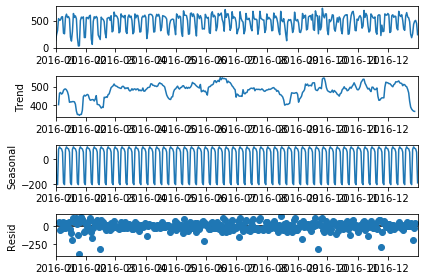

In [19]:
fig = decompose_ts.plot()

#### Lag 1 (diferenciação para análise de sazonalidade

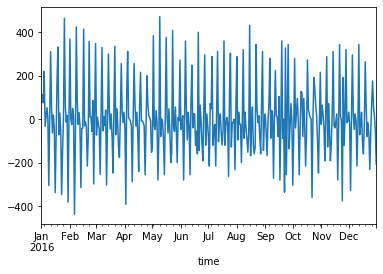

In [20]:
(df_ts['ts'] - df_ts.shift(1)['ts']).plot()

### Separação dos dados

In [21]:
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']

In [22]:
train, test = train_test_split(df_ts, test_size=0.2, shuffle=False)

### Modelagem

In [23]:
model = prophet.Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.5964


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       507.697    0.00189851       78.7071     0.09996           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       507.719   0.000886993       68.9445   1.127e-05       0.001      172  LS failed, Hessian reset 
     135       507.746   1.79438e-08       61.1118      0.2378           1      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [24]:
future = model.make_future_dataframe(periods=test.shape[0], freq='1d')

In [25]:
forecast = model.predict(future)

### Avaliação

In [26]:
def plot_predictions(train, test, pred, datetime_col='ds', pred_col='yhat'):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=train[datetime_col], y=train['y'], name='Train')
    )

    fig.add_trace(
        go.Scatter(x=test[datetime_col], y=test['y'], name='Test')
    )

    fig.add_trace(
        go.Scatter(x=pred[datetime_col], y=pred[pred_col], name='Pred')
    )

    fig.update_layout(showlegend=True)

    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
    
    fig.show()

#### Predições no conjunto de teste

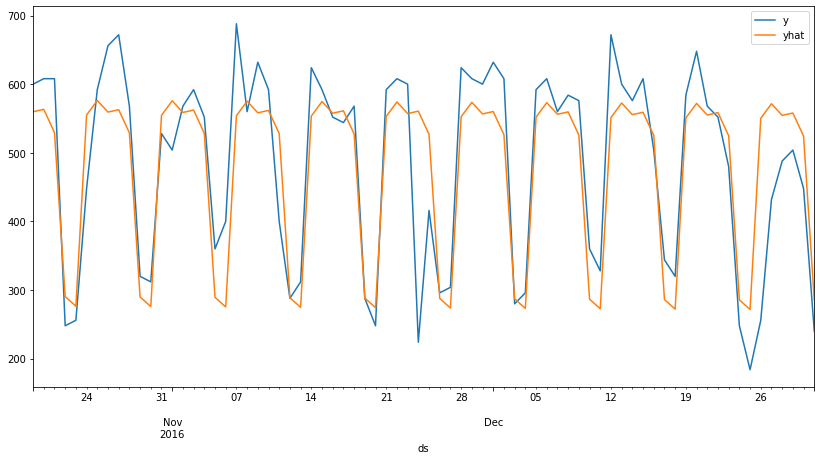

In [27]:
idx_plot = test.index
ax = test.loc[idx_plot].plot(x='ds', y='y', figsize=(14,7))
forecast.loc[idx_plot].plot(x='ds', y='yhat', ax=ax)

#### Visualização da série completa

In [28]:
plot_predictions(train, test, forecast.loc[idx_plot])

#### Componentes

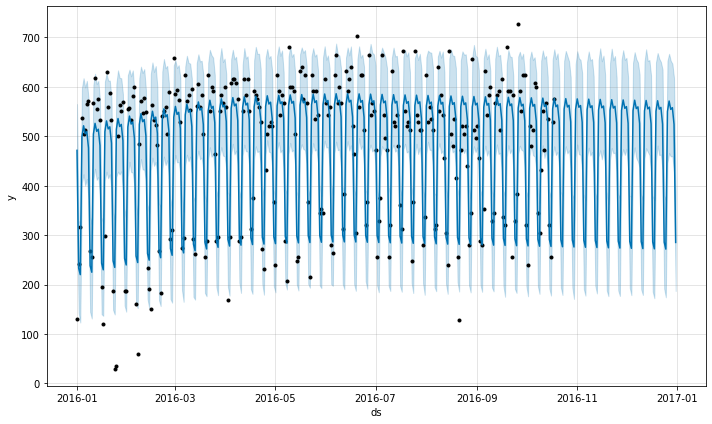

In [29]:
fig = model.plot(forecast)

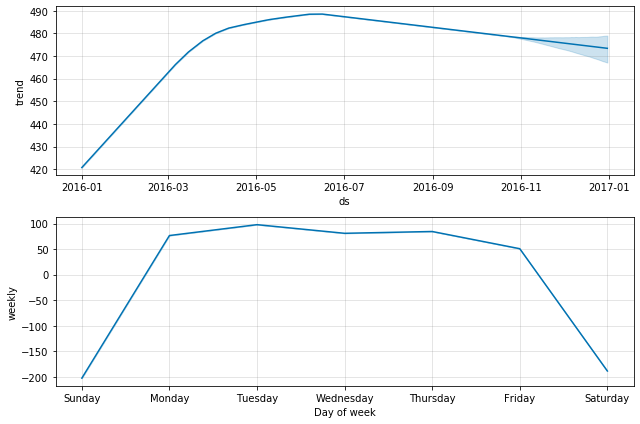

In [30]:
fig = model.plot_components(forecast)

#### Métricas de avaliação

In [31]:
def evaluate_forecast(y_test, pred):
    r2 = r2_score(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print('R2: {:.2f}'.format(r2))
    print('RMSE: {:.2f}'.format(rmse))

In [32]:
evaluate_forecast(test['y'], forecast.loc[test.index]['yhat'])

R2: 0.70
RMSE: 78.54


## Forecast de 4h
Seguindo com mesmo target (entries_diff) da abordagem para forecast de um dia, será realizado para o intervalo de 4h. Além de ter uma granularidade maior, é útil para prever comportamento ao longo do dia, horários de pico, etc. 

In [33]:
df_ts = data[['time', 'entries_diff']].copy()

### Indexação a cada 4h

In [34]:
df_ts = df_ts.set_index('time')
# df_ts = df_ts.asfreq('4h')
df_ts.columns = ['ts']

In [35]:
df_ts.head()

ts
time                     
2016-01-01 00:00:00   NaN
2016-01-01 04:00:00  44.0
2016-01-01 08:00:00   5.0
2016-01-01 12:00:00   8.0
2016-01-01 16:00:00  18.0

In [36]:
## para dados com frequencia de 4h12min
# df_ts['time'] = df_ts['time'].dt.to_period(freq='4H12Min')
# df_ts['time'] = df_ts['time'].dt.to_timestamp()
# df_ts = df_ts.set_index('time')
# df_ts.columns = ['ts']

### Diferenciação (lag 1)

In [37]:
go.Figure(
    go.Scatter(x=df_ts.index, y=df_ts['ts'])
).show()

### Separação dos dados

In [38]:
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']

In [39]:
train, test = train_test_split(df_ts, test_size=0.2, shuffle=False)

### Modelagem

In [40]:
model = prophet.Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -72.9587


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       2556.47    0.00167745       170.956   2.175e-05       0.001      128  LS failed, Hessian reset 
      99          2557   0.000693335       67.8087           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179        2557.9   1.32866e-05        71.383   1.942e-07       0.001      311  LS failed, Hessian reset 
     199        2557.9   2.89055e-06       48.7524      0.8056      0.8056      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        2557.9   2.68592e-07        69.373      0.7401      0.7401      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [41]:
future = model.make_future_dataframe(periods=test.shape[0], freq='4H') # freq='4h12Min'

In [42]:
forecast = model.predict(future)

### Avaliação

#### Predições no conjunto de teste

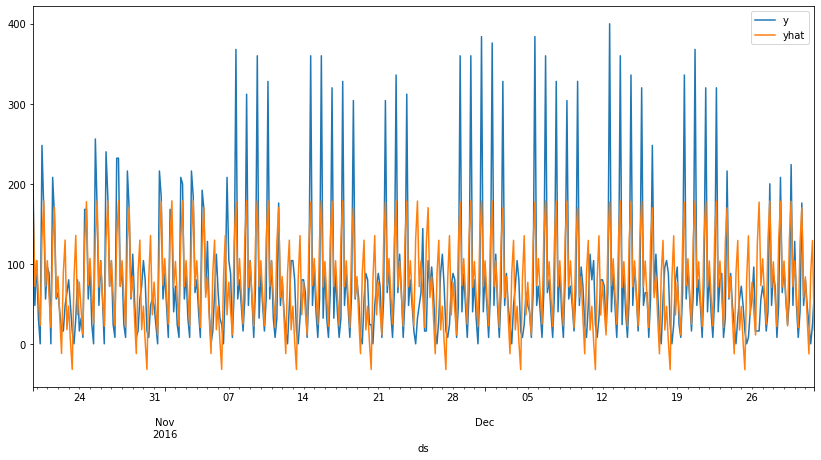

In [43]:
idx_plot = test.index
ax = test.loc[idx_plot].plot(x='ds', y='y', figsize=(14,7))
forecast.loc[idx_plot].plot(x='ds', y='yhat', ax=ax)

In [44]:
plot_predictions(train, test, forecast.loc[idx_plot])

#### Componentes

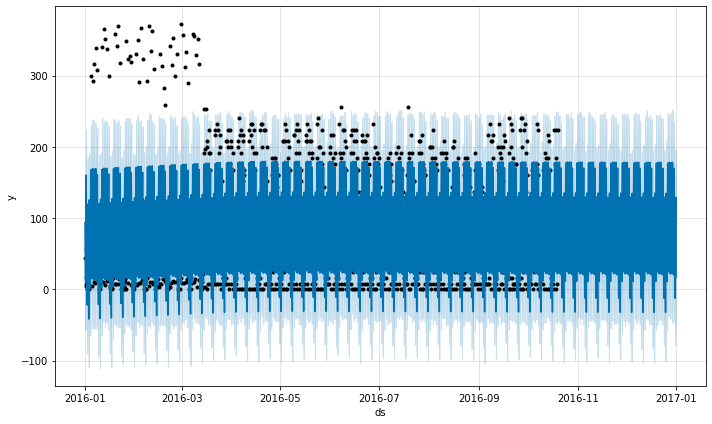

In [45]:
fig = model.plot(forecast)

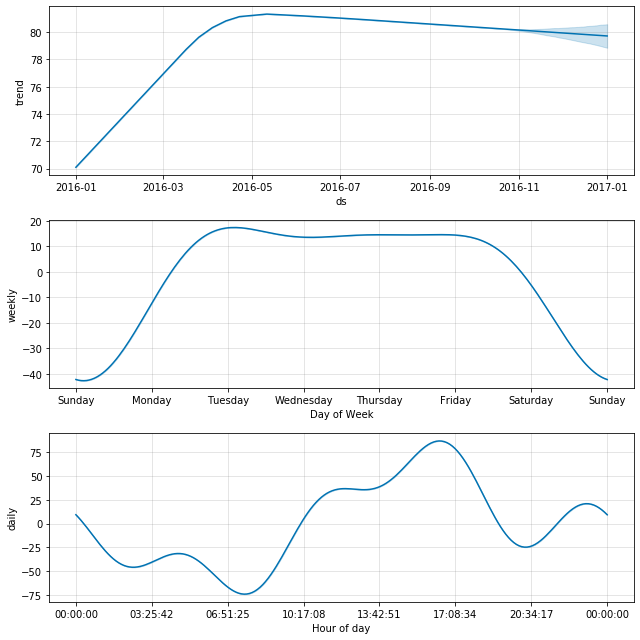

In [46]:
fig = model.plot_components(forecast)

#### Métricas de avaliação

In [47]:
evaluate_forecast(test['y'], forecast.loc[test.index]['yhat'])

R2: 0.44
RMSE: 64.79


### Feature Engineering + Modelos de Machine Learning

### Features

### Features a partir do histórico da série
Utilizando lags e janela deslizante para representar o comportamento histórico 

In [48]:
def create_historical_features(data, column):
    last_4h = data[column].shift(1).rename('last_4h')
    last_12h = data[column].shift(3).rename('last_12h')
    last_24h = data[column].shift(6).rename('last_24h')
    last_7d = data[column].shift(42).rename('last_7d')
    last_1m = data[column].shift(180).rename('last_1m')
    
    rolling_day_avg = data[column].shift(1).rolling(6).mean().rename('last_day_avg')
    rolling_day_median = data[column].shift(1).rolling(6).mean().rename('last_day_median')
    
    rolling_week_avg = data[column].shift(1).rolling(42).mean().rename('last_week_avg')
    rolling_week_median = data[column].shift(1).rolling(42).mean().rename('last_week_median')
    
    rolling_month_avg = data[column].shift(1).rolling(180).mean().rename('last_month_avg')
    rolling_month_median = data[column].shift(1).rolling(180).mean().rename('last_month_median')

    features = pd.concat([
        last_4h, last_12h, last_24h, last_7d, last_1m,
        rolling_day_avg, rolling_day_median,
        rolling_week_avg, rolling_week_median,
        rolling_month_avg, rolling_month_median
    ], axis=1)
    
    features = features.rename(columns=lambda x: column + '_' + x)
    
    return features

#### Features a partir da data e hora
Extrair informações da datahora das instâncias, pois o modelo pode capturar o comportamento de acordo com o período 

In [49]:
def create_datetime_features(data, date_column):
    day = data[date_column].dt.day.rename('day')
    day_of_week = data[date_column].dt.dayofweek.rename('dayofweek')
    hour = data[date_column].dt.hour.rename('hour')
   
    features = pd.concat([
        day, day_of_week, hour
    ], axis=1)
    
    return features

#### Feature para indicar se é feriado
Nesse contexto de transporte, o feriado é bem relevante, pois é provável uma diminuição do fluxo apresentando um comportamento mais similar a um final de semana. Para obter a informação dessas datas, foi utilizado uma base externa disponível no kaggle com feriados de NYC (https://www.kaggle.com/pceccon/nyc2016holidays).

In [51]:
df_holidays = pd.read_csv('../data/external/NYC_2016Holidays.csv', sep=';')

In [52]:
df_holidays

Day          Date                     Holiday
0     Friday    January 01               New Years Day
1     Monday    January 18  Martin Luther King Jr. Day
2     Friday   February 12          Lincoln's Birthday
3     Monday   February 15             Presidents' Day
4     Sunday        May 08                Mother's Day
5     Monday        May 30                Memorial Day
6     Sunday       June 19                Father's Day
7     Monday       July 04            Independence Day
8     Monday  September 05                   Labor Day
9     Monday    October 10                Columbus Day
10    Friday   November 11                Veterans Day
11  Thursday   November 24                Thanksgiving
12    Monday   December 26     Christmas Day (in lieu)
13    Monday       July 04            Independence Day
14   Tuesday   November 08                Election Day

In [53]:
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'], format='%B %d')

In [54]:
df_holidays['Date'] = df_holidays['Date'] + pd.DateOffset(years=116)

In [55]:
df_holidays = df_holidays.drop_duplicates(['Date']).sort_values('Date')

In [56]:
def create_holiday_feature(data):
    data = pd.merge(
        data, df_holidays[['Date', 'Holiday']],
        left_on=df['ds'].dt.date, right_on=df_holidays['Date'].dt.date,
        how='left'
    )
    
    data = data.drop(['key_0', 'Date'], axis=1)
    
    idx_holidays = data[~data['Holiday'].isnull()].index
    data.loc[idx_holidays, 'Holiday'] = 1
    data['Holiday'].fillna(0, inplace=True)
    
    return data

### Junção das features

In [57]:
historical_features = create_historical_features(df_ts, 'y')
datetime_features = create_datetime_features(df_ts, 'ds')

df = pd.concat([df_ts, historical_features, datetime_features], axis=1)

In [58]:
df = create_holiday_feature(df)

In [59]:
df.tail()

ds     y  y_last_4h  y_last_12h  y_last_24h  y_last_7d  \
2191 2016-12-31 04:00:00  48.0       80.0       176.0        48.0       48.0   
2192 2016-12-31 08:00:00  24.0       48.0        48.0         8.0       24.0   
2193 2016-12-31 12:00:00   0.0       24.0        80.0        40.0        0.0   
2194 2016-12-31 16:00:00  24.0        0.0        48.0       176.0       32.0   
2195 2016-12-31 20:00:00  64.0       24.0        24.0        48.0       56.0   

      y_last_1m  y_last_day_avg  y_last_day_median  y_last_week_avg  \
2191       48.0       66.666667          66.666667        60.761905   
2192        8.0       66.666667          66.666667        60.761905   
2193       64.0       69.333333          69.333333        60.761905   
2194      376.0       62.666667          62.666667        60.761905   
2195       48.0       37.333333          37.333333        60.571429   

      y_last_week_median  y_last_month_avg  y_last_month_median  day  \
2191           60.761905         80.177778            80.177778   31   
2192           60.761905         80.177778            80.177778   31   
2193           60.761905         80.266667            80.266667   31   
2194           60.761905         79.911111            79.911111   31   
2195           60.571429         77.955556            77.955556   31   

      dayofweek  hour  Holiday  
2191          5     4        0  
2192          5     8        0  
2193          5    12        0  
2194          5    16        0  
2195          5    20        0

### Separação dos dados

In [60]:
X = df.drop(['ds', 'y'], axis=1)
y = df['y']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [62]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

### Modelagem

In [63]:
model = GradientBoostingRegressor(random_state=17)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=17)

In [64]:
pred = model.predict(X_test)

### Avaliação

#### Métricas de avaliação

In [65]:
evaluate_forecast(y_test, pred)

R2: 0.82
RMSE: 37.15


In [66]:
pred_df = pd.DataFrame(pred, columns=['pred'])
pred_df['ds'] = test['ds'].reset_index(drop=True)
pred_df = pred_df.set_index(test.index)

#### Predições no conjunto de teste

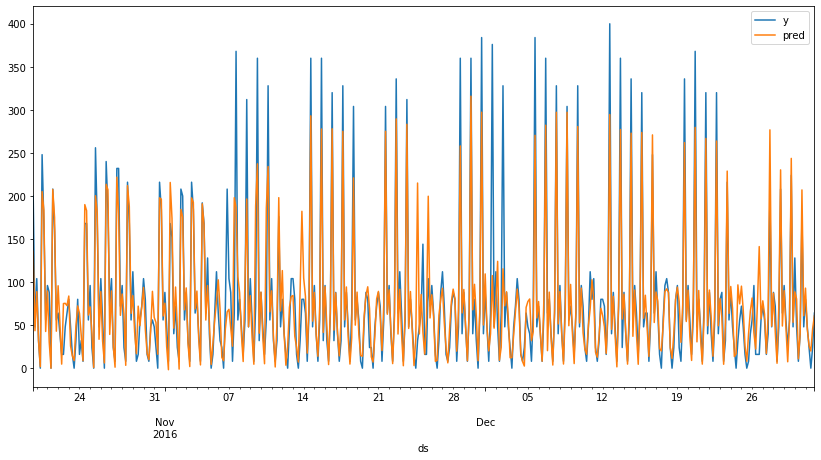

In [67]:
idx_plot = test.index
ax = test.loc[idx_plot].plot(x='ds', y='y', figsize=(14,7))
pred_df.loc[idx_plot].plot(x='ds', y='pred', ax=ax)

#### Série completa

In [68]:
plot_predictions(df.loc[y_train.index], test, pred_df, datetime_col='ds', pred_col='pred')

## Juntar os dados de todos anos disponíveis para uma linha

In [71]:
df_year = pd.read_csv("../data/raw/{}.csv.gz".format(2010))

In [72]:
ca = 'R610'
scp = '00-04-01'

In [73]:
df_filtered = df_year[(df_year['ca'] == ca) & (df_year['scp'] == scp)]

In [75]:
list_years = list(range(2010, 2018))
ca = 'R610'
scp = '00-04-01'
list_dfs = []
for year in list_years:
    print(year)
    df_year = pd.read_csv("../data/raw/{}.csv.gz".format(year))
    df_filtered = df_year[(df_year['ca'] == ca) & (df_year['scp'] == scp)]
    print(df_filtered.shape)
    list_dfs.append(df_filtered)

2010
(1623, 10)
2011
(2402, 10)
2012
(2476, 10)
2013
(2436, 10)
2014
(2314, 10)
2015
(2235, 10)
2016
(2345, 10)
2017
(1640, 10)


In [76]:
df_complete = pd.concat(list_dfs)

In [77]:
df_complete.to_csv('../data/processed/data_sample_complete.csv', index=False)

## Conclusão

- Os dados apresentaram algumas falhas, como mudança bruscas de escala e falta de alguns valores. Porém essa quantidade foi pequena e o tratamento não causa impacto nos resultados, ainda assim essa afirmaçõa não pode ser generalizada para outras linhas e estações.
- O processo pode ser replicado para outras linhas e estações, mas provavelmente alguma pode precisar de algum tratamento específico.
- Foram realizados forecast com intervalos de 1 dia e de 4h. O primeiro, apresentou uma tendência mais claro e fácil de identificar, com um comportamento bem definido. O segundo também tem, mas apresenta mais ruídos. A abordagem pode ter mais impacto por entrar num detalhe maior (intervalos mais curtos).
- A construção de features e treinamento de um regressor apresentou melhor desempenho que a abordagem com o Prophet.
- O dado externo com informações de feriados foi útil para o problema.
- Por fim, foi exportado uma base com mais anos dessa linha para um treinamento com mais dados e testando outros modelos.